In [11]:
import numpy as np
import os, glob, yaml, json, lz4.frame
from tutorials.utils import plotting
from tutorials.utils import plot_new
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [12]:
def compare_prod_equal(coins_dict, env):
    fig, ax = plt.subplots(1, 1, figsize=(8, 8), sharey=False)
    plt.subplots_adjust(left=0.08, right=0.92, top=0.92, bottom=0.08)

    exps = coins_dict.keys()

    planner_util = {}
    productivity = {}
    equality = {}

    for idx, exp_name in enumerate(exps):
        exp_log = coins_dict[exp_name]
        accum_reward = 0
        p_reward = []
        for x in exp_log["rewards"]:
            accum_reward += x['p']
            p_reward.append(accum_reward)

            agent_coin = {}
            for i in range(3):
                agent_coin[i] = [x[str(i)]["inventory"]['Coin'] + x[str(i)]["escrow"]['Coin'] for x in exp_log["states"]]

        planner_util[exp_name] = p_reward[-1]
        prod = np.array([agent_coin[i][-1] for i in range(3)]).sum()
        productivity[exp_name] = prod
        equality[exp_name] = p_reward[-1] / prod

    cmap_tax = plt.get_cmap("tab20", len(exps))
    for idx, exp_name in enumerate(exps):
        prod = productivity[exp_name]
        equal = equality[exp_name]
        # print(f"[{exp_name}] Prod {prod}, Equal {equal}")

        # circle = patches.Circle((prod, equal), 0.2, facecolor=cmap_tax(idx), lw=2, label=f"{exp_name}")
        # ax.add_patch(circle)
        ax.scatter(prod, equal, s=50, color=cmap_tax(idx), label=f"{exp_name}")
        ax.set_xlabel(f"Productivity")
        ax.set_ylabel("Equality (1 - Gini)")
        ax.set_title("Productivity x Equality")
        ax.legend()
    plt.savefig(f"./plots/compare_prod_equal_{env}.png")
    plt.close()


In [13]:
def compare_tax_policy(dense_log_dict, env):
    fig, axes = plt.subplots(3, 1, figsize=(10, 20), sharey=False)
    plt.subplots_adjust(left=0.08, right=0.92, top=0.92, bottom=0.08)
    exps = dense_log_dict.keys()

    cutoff_list = []
    cutoff_flag = False

    rate_exp = {}

    for idx, exp_name in enumerate(exps):
        exp_log = dense_log_dict[exp_name]
        rate_period = {}
        period_cnt = 0
        for x in exp_log['PeriodicTax']:
            if isinstance(x, dict):
                if not cutoff_flag:
                    for tax_cutoff_val in x['cutoffs']:
                        cutoff_list.append(int(tax_cutoff_val))
                    cutoff_flag = True

                rate_list = []
                for tax_rate in x['schedule']:
                    rate_list.append(tax_rate + idx * 0.008)
                rate_period[period_cnt] = rate_list
                period_cnt += 1
        
        rate_exp[exp_name] = rate_period

    cutoffs_ext = cutoff_list + [cutoff_list[-1] + 50]
    num_bracket = len(cutoff_list)

    # tab20
    cmap_tax = plt.get_cmap("tab20", len(exps))
    for period in range(period_cnt):
        ax = axes[period]
        # ax.vlines(cutoff_list, -0.95, 1.0, colors='b', linestyles='dashed', lw=1)
            
        for idx, exp_name in enumerate(exps):
            rate_period = rate_exp[exp_name]
            rate_list = rate_period[period]
            ax.hlines(rate_list, cutoff_list, cutoffs_ext[1:], lw=2, 
                    colors=cmap_tax(idx), label=f"{exp_name}")

            ax.set_title(f"Tax Rate Brackets in Period {period}")
            ax.set_xticks(cutoff_list[1:])
            ax.set_xlim([cutoffs_ext[0], cutoffs_ext[-1]])
            ax.set_ylim([-0.05, 1.0])
            ax.set_xlabel(f"Tax Bracket")
            ax.set_ylabel("Marginal Tax Rate(%)")
            ax.legend()

    plt.savefig(f"./plots/compare_tax_{env}.png")
    plt.close()

In [14]:
scenarios = ['1-no_oracle', '2-constant', '3-rule_based', '4-one_tax_bracket', '5-monte_carlo']
envs = ["env000.lz4", "env001.lz4", "env002.lz4", "env003.lz4"]

def load_episode_log(filepath):
    with lz4.frame.open(filepath, mode="rb") as log_file:
        log_bytes = log_file.read()
    return json.loads(log_bytes)

# def get_latest_log(root):
#     log_folders = [item for item in os.listdir(root) if item.startswith('logs_')]
#     if not log_folders:
#         return None  
#     log_folders.sort()
#     return log_folders[-1]

def visualize_logs(scenario, phase, env):
    log_dir = f"/home/zilong/Downloads/dense_logs"
    exps_dir = sorted(glob.glob(log_dir+'/*'))
    
    env_name = envs[env]
    exp_names = []
    dense_log_dict = {}

    for exp_path in exps_dir:
        exp_name = os.path.basename(exp_path)
        exp_names.append(exp_name)
        dense_log_exp = f"{exp_path}/{env_name}"
        dense_log_dict[exp_name] = load_episode_log(dense_log_exp)

    compare_tax_policy(dense_log_dict, env)
    compare_prod_equal(dense_log_dict, env)

    # print(dense_logs.keys())
    # for key in dense_logs.keys():
    #     with open(f'dense_log_{key}.yaml', 'w') as file:
    #         yaml.dump(dense_logs[key], file, default_flow_style=False)

    # plotting layout
    for exp in exp_names:
        exp_log = dense_log_dict[exp]

        (fig0,fig1,fig2,fig3,fig4), _, _, _, _ = plot_new.breakdown(exp_log)
        fig2.savefig(f"./plots/{exp}-gain-{env}.png")
        fig3.savefig(f"./plots/{exp}-pay-{env}.png")
        fig4.savefig(f"./plots/{exp}-tax-{env}.png")

        plt.close()

/home/zilong/Disk_sda6/AI_Econ/tutorials/utils/plot_new.py:527: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig4, axes = plt.subplots(1, 1, figsize=(10, 6), sharey=False)


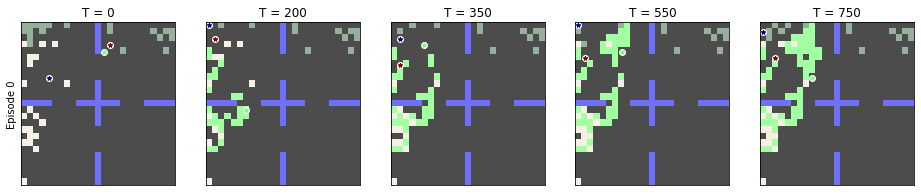

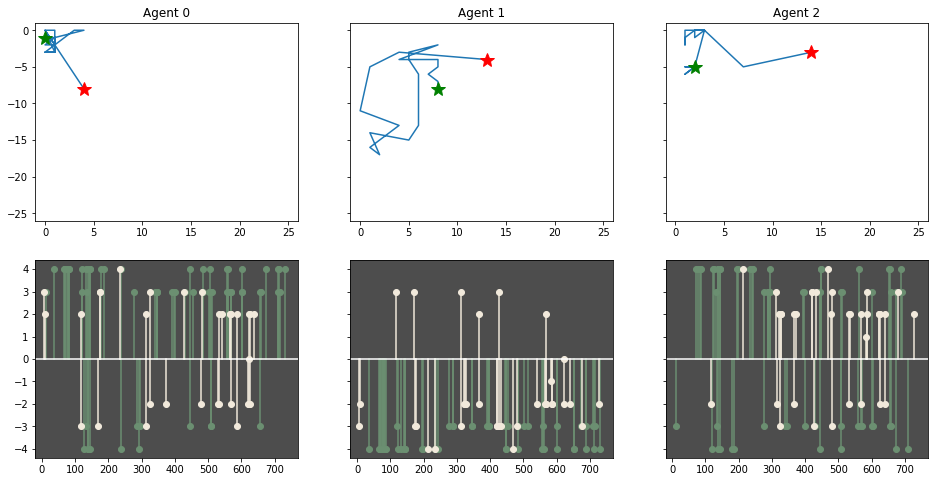

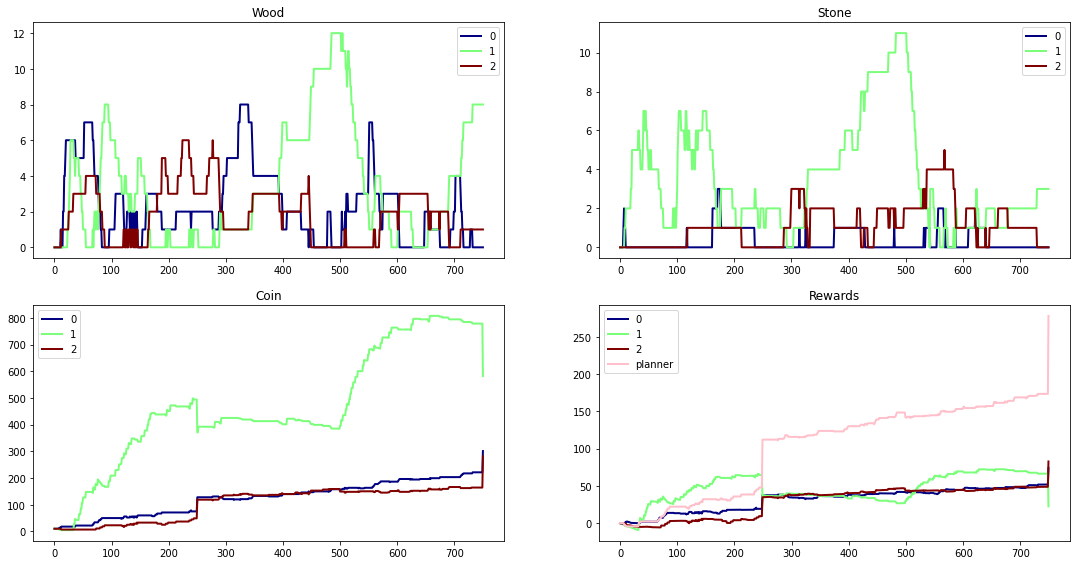

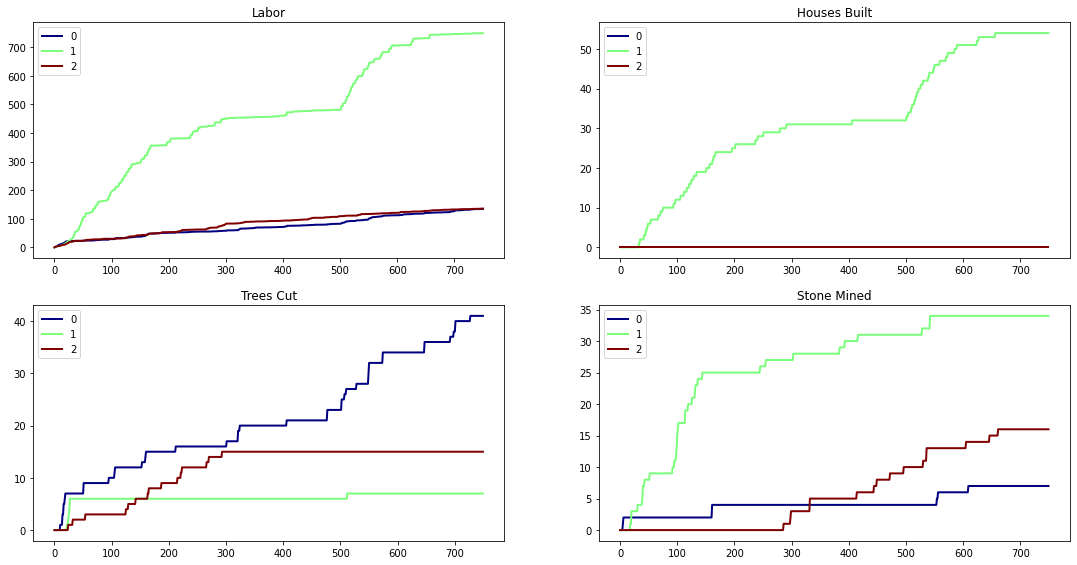

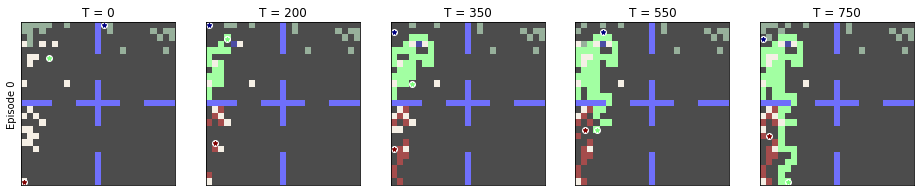

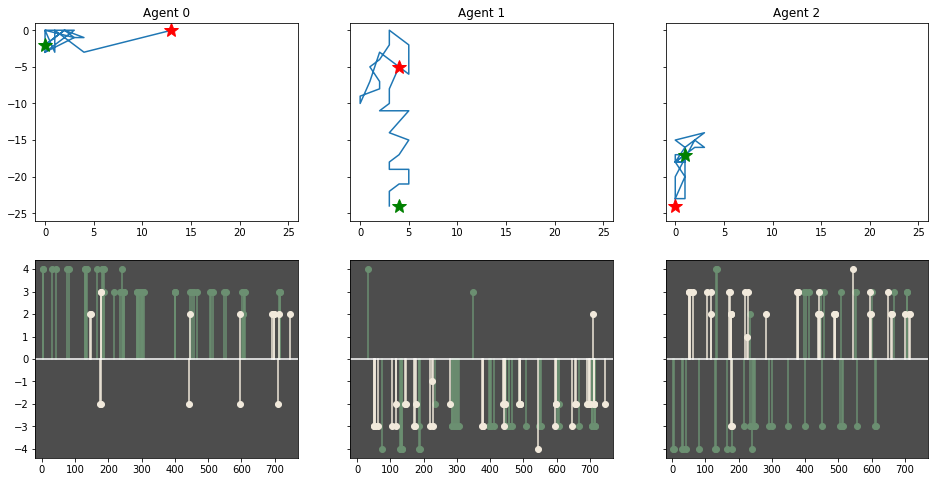

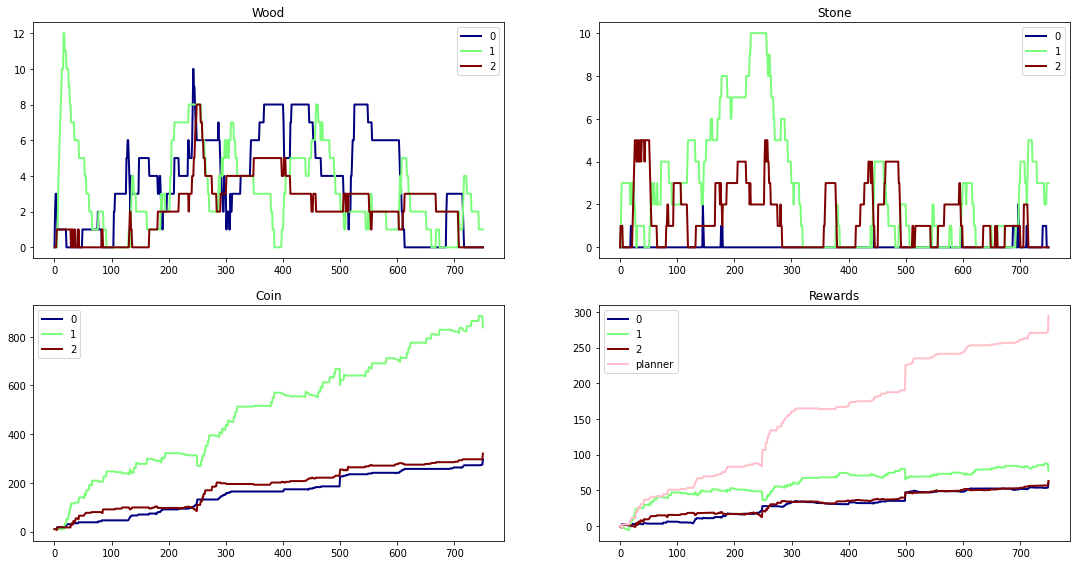

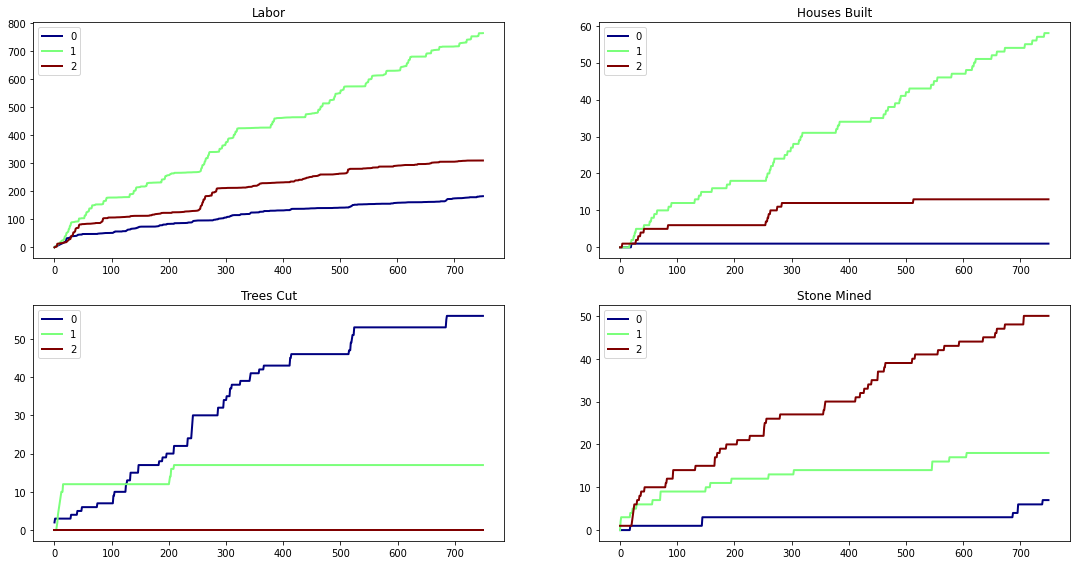

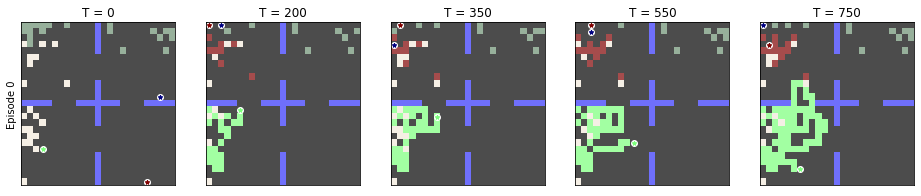

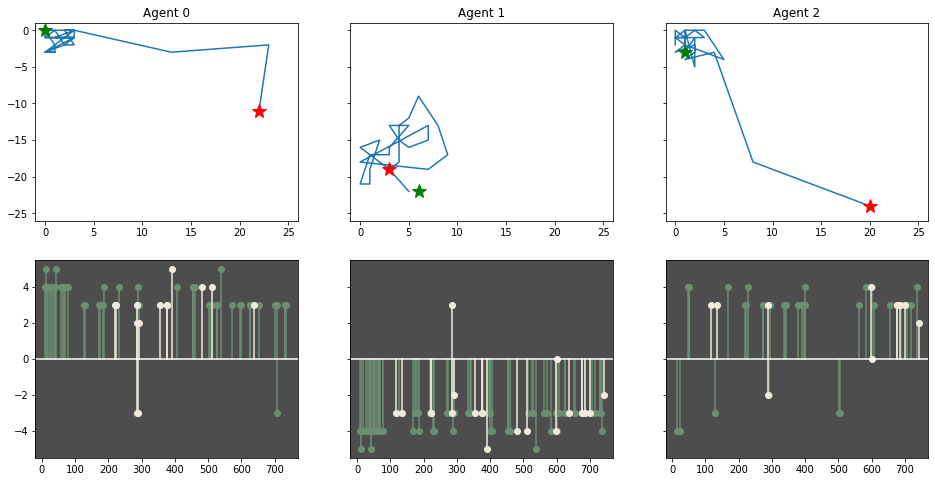

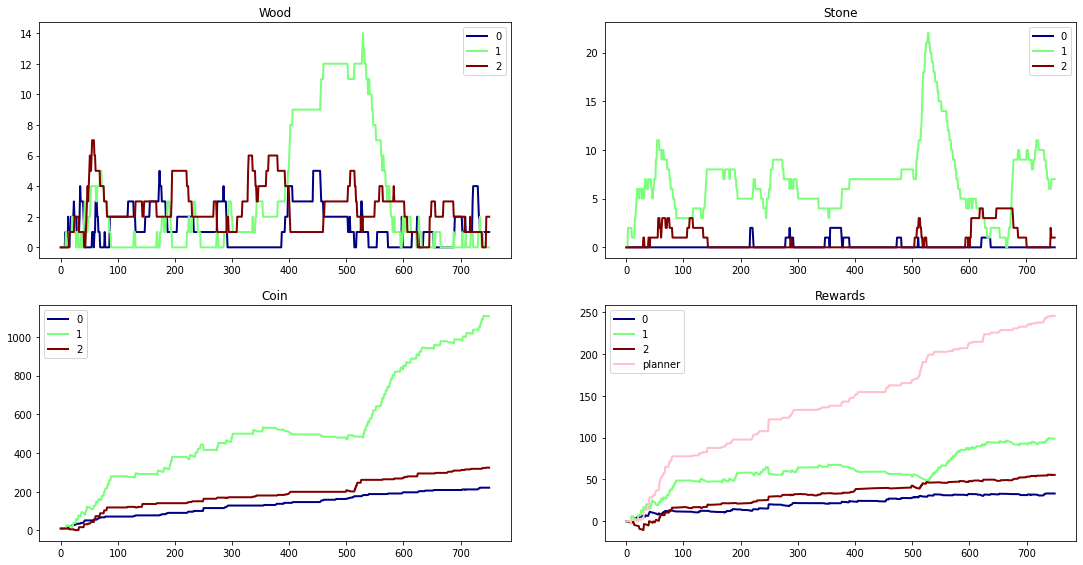

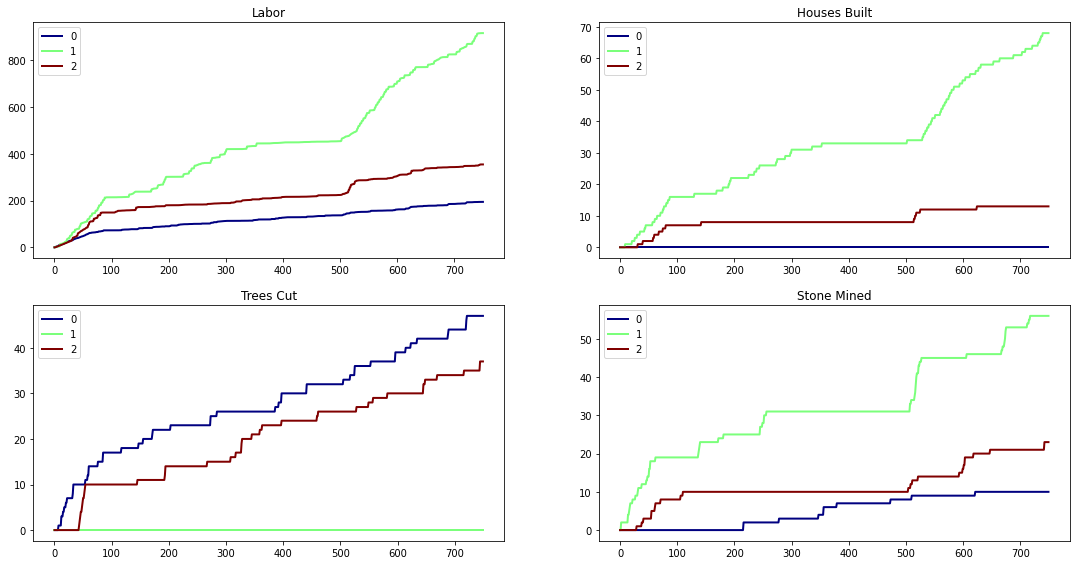

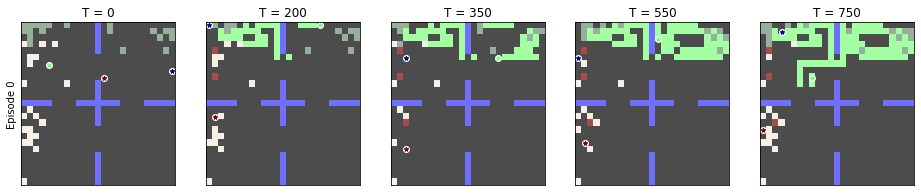

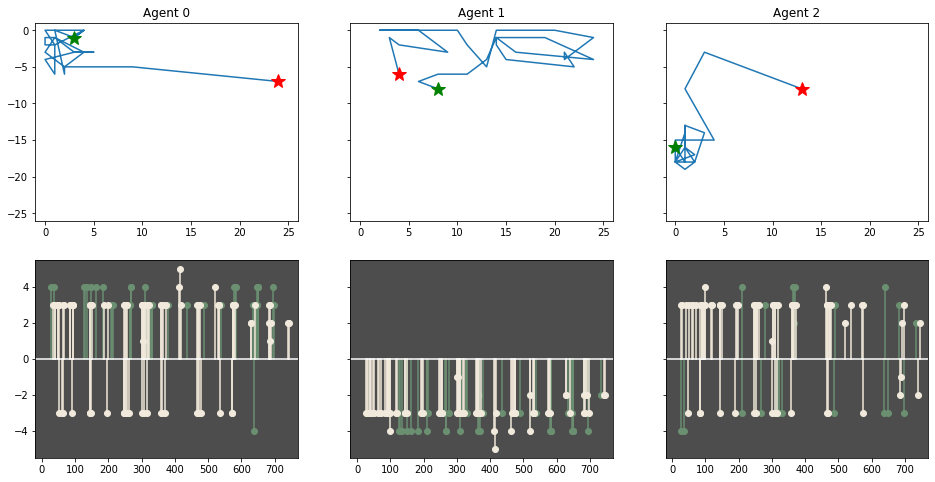

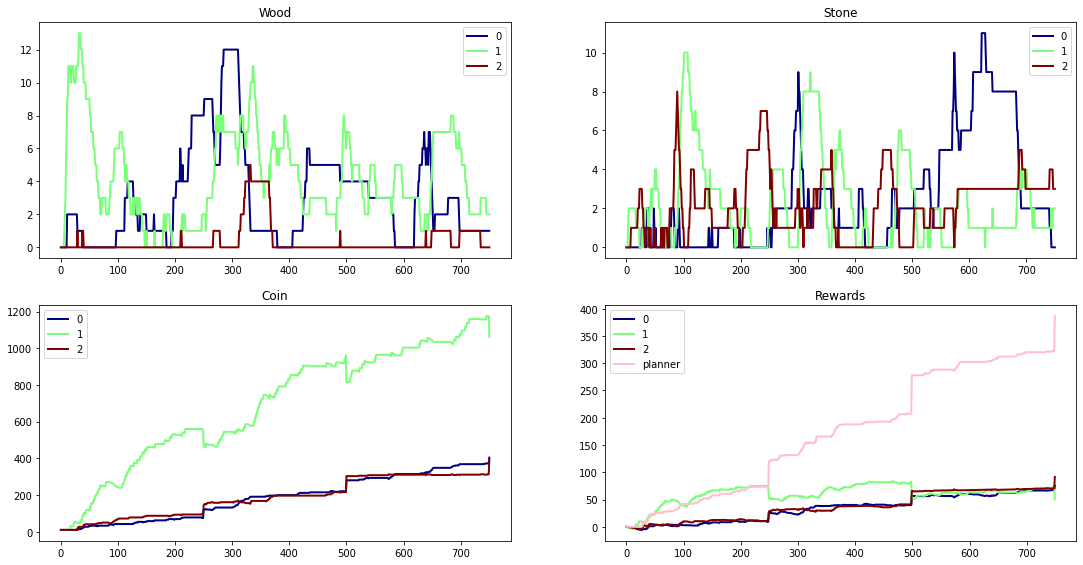

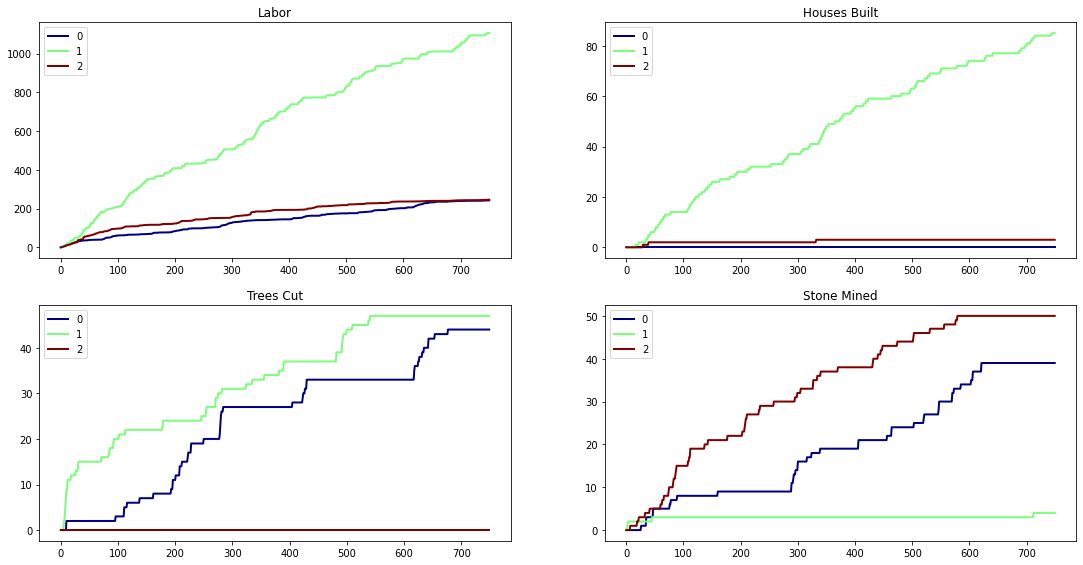

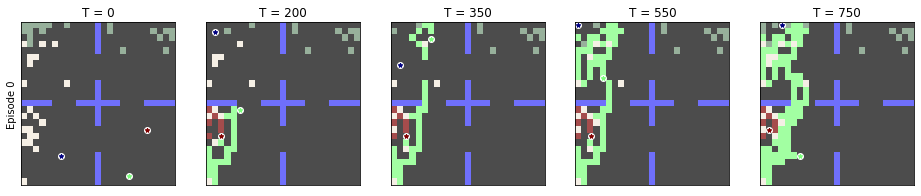

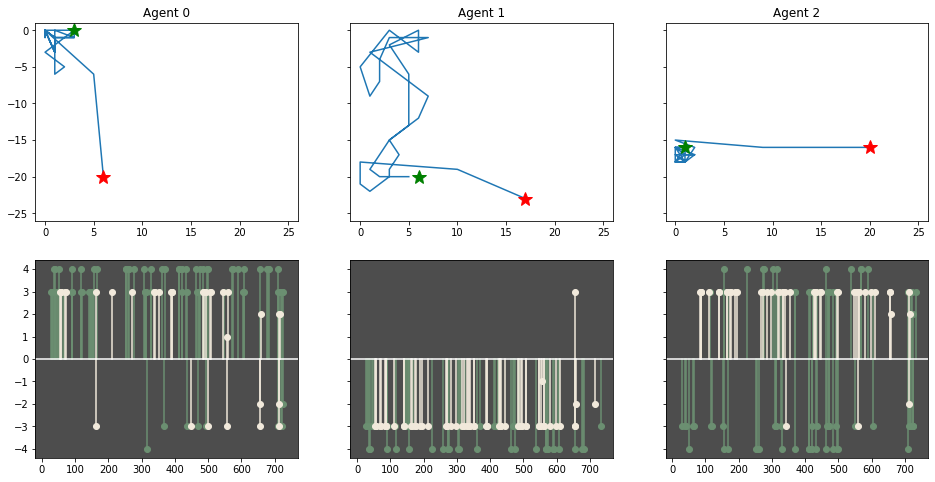

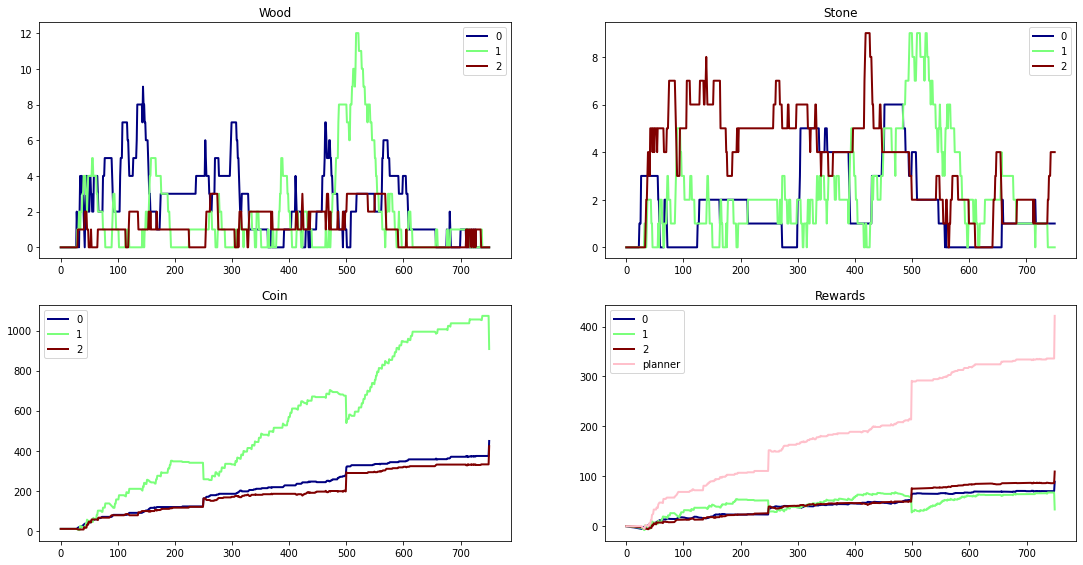

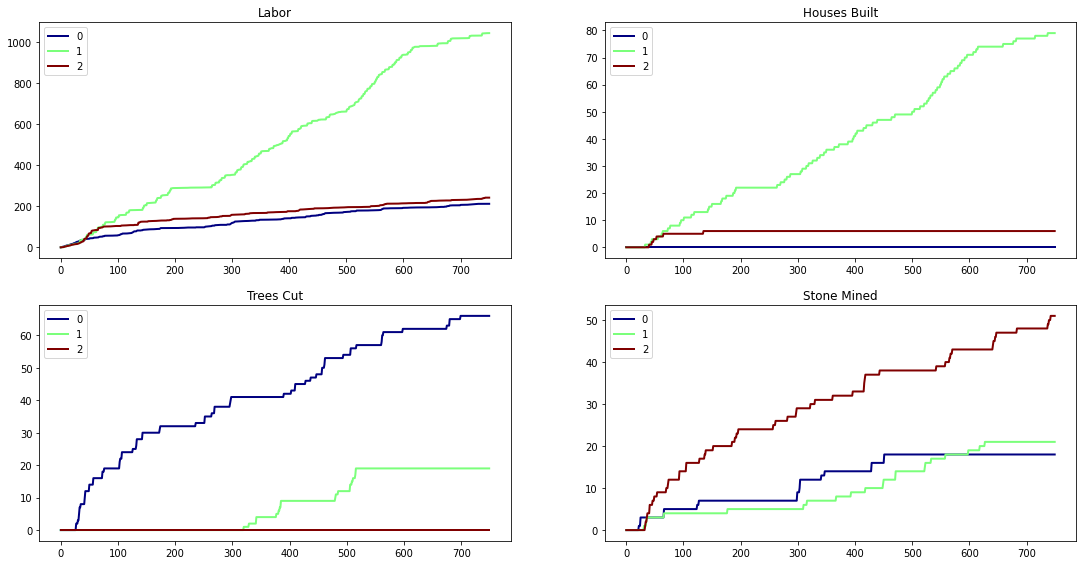

In [15]:
for env in range(len(envs)):
    visualize_logs(scenario=1, phase="phase2", env=env)
    break